In [13]:
from math import ceil
from itertools import combinations, product

import numpy as np
import jax.numpy as jnp
import jax
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import scipy.signal


np.set_printoptions(precision=2, linewidth=200)

In [114]:
# Set seed for reproducibility
key = jax.random.PRNGKey(0)

# Create a random collection of interconnected microgrids
N_grids = 5
min_generators_per_grid = 1
max_generators_per_grid = 5

generator_inertia_avg = 10.
generator_inertia_std = 4.
generator_inertia_std_within_grid = 2.

intergrid_susceptance_min = 0.1
intergrid_susceptance_max = 3.0
intragrid_susceptance_avg = 50.0
susceptance_std = 3

generator_damping = 2

# Choose how many generators are in each grid
key, subkey = jax.random.split(key)
generators_per_grid = jax.random.randint(subkey, (N_grids,), min_generators_per_grid, max_generators_per_grid)

# Choose the average inertia of each grid and the inertia of the generators in each grid
key, subkey = jax.random.split(key)
grid_avg_inertias = generator_inertia_avg + generator_inertia_std * jax.random.normal(subkey, (N_grids,))

keys = jax.random.split(key, N_grids + 1)
key = keys[0]
subkeys = keys[1:]
generator_inertias = [
    avg_inertia + generator_inertia_std_within_grid * jax.random.normal(subkey, (n_generators,))
    for subkey, n_generators, avg_inertia in zip(subkeys, generators_per_grid, grid_avg_inertias)
]

# Choose the susceptance between grids (we'll only use the upper right triangle of this matrix)
node_combinations = list(combinations(range(N_grids), 2))
keys = jax.random.split(key, len(node_combinations) + 1)
key = keys[0]
subkeys = keys[1:]
intergrid_susceptance = {
    (i, j): jax.random.uniform(subkey, minval=intergrid_susceptance_min, maxval=intergrid_susceptance_max)
    for subkey, (i, j) in zip(subkeys, node_combinations)
    if i != j
}
key, subkey = jax.random.split(key)
intergrid_susceptance[("Reference", 0)] = jax.random.uniform(subkey, minval=intergrid_susceptance_min, maxval=intergrid_susceptance_max)

# Choose the susceptance between each generator and its grid
keys = jax.random.split(key, N_grids + 1)
key = keys[0]
subkeys = keys[1:]
generator_susceptance = [
    intragrid_susceptance_avg + susceptance_std * jax.random.normal(subkey, (n_generators,))
    for subkey, n_generators in zip(subkeys, generators_per_grid)
]

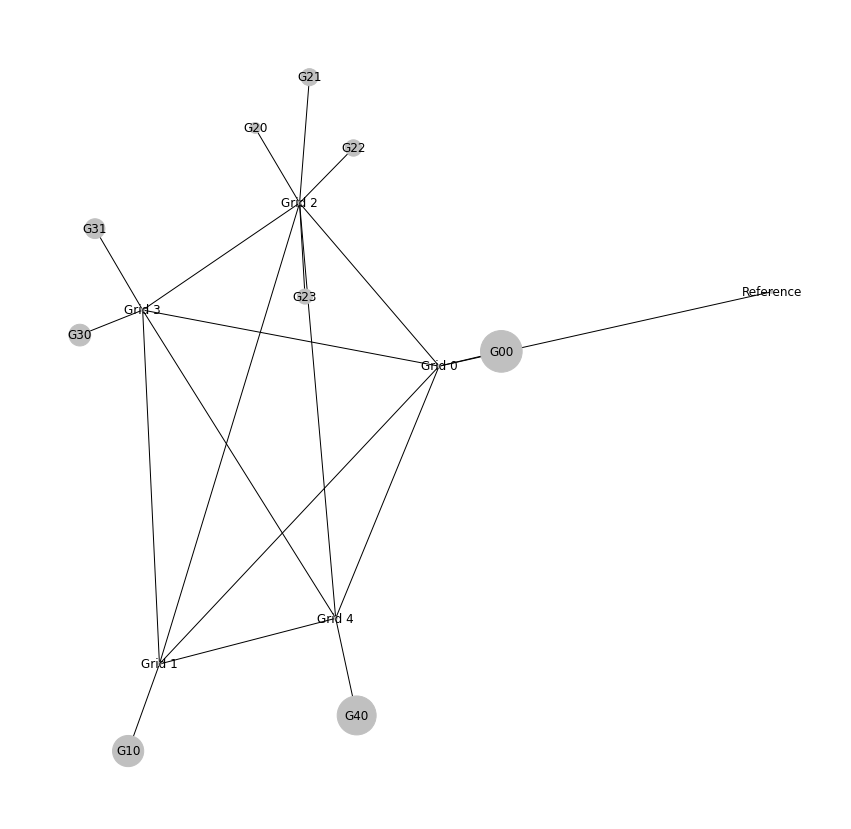

In [250]:
# Visualize the network
G = nx.Graph()

# Add buses for all of the grids
for i in range(N_grids):
    G.add_node(f"Grid {i}", inertia=0.1)

G.add_node(f"Reference", inertia=0.1)

# Add edges with the appropriate weight between grids
for connection, susceptance in intergrid_susceptance.items():
    node_a = f"Grid {connection[0]}" if isinstance(connection[0], int) else "Reference"
    node_b = f"Grid {connection[1]}"
    G.add_edge(node_a, node_b, susceptance=susceptance, reactance=1/susceptance)
    
# Add the generators in each grid
for i in range(N_grids):
    grid_name = f"Grid {i}"
    for j in range(generators_per_grid[i]):
        node_name = f"G{i}{j}"
        susceptance = generator_susceptance[i][j]
        G.add_node(node_name, inertia=generator_inertias[i][j])
        G.add_edge(node_name, grid_name, susceptance=susceptance, reactance=1/susceptance)


# Plot with a spring layout
plt.subplots(figsize=(15, 15))
pos = nx.spring_layout(G, scale=10, seed=0, weight="susceptance")
inertias = [100 * n[1]["inertia"] for n in G.nodes.data()]
nx.draw(G, pos=pos, node_size=inertias, with_labels=True, node_color="silver")

In [251]:
def susceptance_matrix_from_graph(G, node_names, reference_node_name):
    """
    Compute the susceptance matrix between all generator nodes in the given graph.
    
    args:
        G: a networkx.Graph
        node_names: a list of names of nodes between which the susceptances
            will be calculated.
        reference_node_name: the name of the reference node
    returns:
        a np array of the susceptance matrix for the given network
    """
    N_G = len(generator_names)
    susceptance_matrix = jnp.zeros((N_G, N_G))
    for i, Gi in enumerate(node_names):
        for j, Gj in enumerate(node_names):
            # There are two cases. Mutual susceptance is easy, since it's the reciprocal of
            # the reactance distance between two nodes
            if i != j:
                susceptance_matrix = susceptance_matrix.at[i, j].set(
                    1 / nx.resistance_distance(G, Gi, Gj, weight="reactance")
                )

    # The self-susceptance is calculated from the sum of other susceptances minus the
    # susceptance to the reference node
    for i, Gi in enumerate(generator_names):
        susceptance_to_reference = 1 / nx.resistance_distance(G, Gi, reference_node_name, weight="reactance")
        susceptance_matrix = susceptance_matrix.at[i, i].set(
            -susceptance_matrix[i, :].sum() - susceptance_to_reference
        )
    
    return susceptance_matrix

# Get the susceptance matrix by computing the resistance distance between each generator
generator_names = [
    f"G{i}{j}"
    for i in range(N_grids)
    for j in range(generators_per_grid[i])
]
susceptance_matrix = susceptance_matrix_from_graph(G, generator_names, "Reference")

In [249]:
susceptance_matrix

DeviceArray([[ -39.46,    2.69,    5.29,    5.27,    5.32,    5.27,    5.28,    5.32,    4.09],
             [   2.69,  -27.75,    3.61,    3.6 ,    3.62,    3.59,    3.6 ,    3.62,    2.72],
             [   5.29,    3.61, -136.16,   24.06,   25.23,   23.95,   23.65,   24.52,    5.04],
             [   5.27,    3.6 ,   24.06, -134.54,   24.8 ,   23.57,   23.28,   24.12,    5.03],
             [   5.32,    3.62,   25.23,   24.8 , -139.23,   24.69,   24.37,   25.3 ,    5.07],
             [   5.27,    3.59,   23.95,   23.57,   24.69, -134.12,   23.18,   24.02,    5.02],
             [   5.28,    3.6 ,   23.65,   23.28,   24.37,   23.18, -134.1 ,   24.89,    5.03],
             [   5.32,    3.62,   24.52,   24.12,   25.3 ,   24.02,   24.89, -137.67,    5.07],
             [   4.09,    2.72,    5.04,    5.03,    5.07,    5.02,    5.03,    5.07,  -37.85]], dtype=float32)

In [268]:
# Define inertia and damping matrices
N_G = len(generator_names)
J = jnp.diag(jnp.array([G.nodes[generator_name]["inertia"] for generator_name in generator_names]))
damping_matrix = jnp.diag(jnp.array([generator_damping] * N_G))
# Define the gains of the AGC matrices (delta Pm = -K(omega - omega_ref))
agc_gain_matrix = jnp.diag(jnp.array([0.1] * N_G))
# Make some generators a bit twitchy
i = [0, 1]
agc_gain_matrix = agc_gain_matrix.at[i, i].set(0.6)
omega_ref = 0.0  # incremental

# For convenience when simulating, invert the inertia matrix
Jinv = jnp.linalg.inv(J)

# This let's us define the dynamics of the interconnected system
def dynamics(state, loads, mechanical_power):
    """
    Return the time derivative of state
    
    args:
        state: (2 * N_G) vector of state [delta, omega, governor_power, governor_throttle]
            (measured relative to a reference)
        loads: (N_G) vector of loads at each generator node
        mechanical_power: (N_G) vector of (uncontrolled) mechanical power input at each node
    """
    # Unpack state
    N_G = int(state.shape[0] // 4)
    delta = state[:N_G]
    omega = state[N_G:2*N_G]
    governor_power = state[2*N_G:3*N_G]
    governor_throttle = state[3*N_G:]
    
    # Derivative of position is velocity
    ddt_delta = omega
    
    # Derivative of velocity
    net_power_input = mechanical_power - loads + susceptance_matrix @ delta + governor_power
    damping_torque = - damping_matrix @ omega
    ddt_omega = Jinv @ (net_power_input + damping_torque)
    
    # derivative of governor states
    ddt_governor_power = governor_throttle
    ddt_governor_throttle = - agc_gain_matrix @ (omega - omega_ref)
    
    # Stack
    return jnp.hstack((ddt_delta, ddt_omega, ddt_governor_power, ddt_governor_throttle))

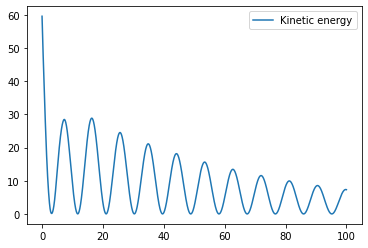

In [269]:
# Now we can simulate the system response
x0 = jnp.zeros((N_G * 4,))  # delta, omega, governor_power, governor_throttle
x0 = x0.at[N_G:2*N_G].set(1.0)

T_sim = 100.0
dt = 0.01
tsteps = int(T_sim // dt)

loads = jnp.zeros((tsteps, N_G))
mechanical_powers = jnp.zeros((tsteps, N_G))

def step(current_state, inputs):
    loads, mechanical_power = inputs
    next_state = current_state + dt * dynamics(current_state, loads, mechanical_power)
    return next_state, next_state

_, xs = jax.lax.scan(step, x0, (loads, mechanical_powers))

omega = xs[:, N_G:]
kinetic_energy = jax.vmap(lambda omega: omega.T @ J @ omega)(xs[:, N_G:2*N_G])

t_range = np.arange(0, T_sim - dt, dt)
i = 5  # which generator to plot
plt.plot(t_range, kinetic_energy, label="Kinetic energy")
plt.legend()